In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import math
from threading import Thread
import cv2

# Start the camera

In [2]:
from picamera2 import Picamera2

cam = Picamera2()
config = cam.create_video_configuration(
	buffer_count=1,
	queue=False,
	main={
		"size": (640, 480)
	}
)
cam.configure(config)
cam.start()

def get_frame(): return cam.capture_array()[:,:,:3]

[0:35:00.445655620] [4306]  INFO Camera camera_manager.cpp:327 libcamera v0.4.0+53-29156679
[0:35:00.452941525] [4323]  INFO RPI pisp.cpp:720 libpisp version v1.1.0 e7974a156008 27-01-2025 (21:50:51)
[0:35:00.462923664] [4323]  INFO RPI pisp.cpp:1179 Registered camera /base/axi/pcie@120000/rp1/i2c@88000/imx219@10 to CFE device /dev/media0 and ISP device /dev/media2 using PiSP variant BCM2712_D0
[0:35:00.466573831] [4306]  INFO Camera camera.cpp:1202 configuring streams: (0) 640x480-XBGR8888 (1) 640x480-BGGR_PISP_COMP1
[0:35:00.466675846] [4323]  INFO RPI pisp.cpp:1484 Sensor: /base/axi/pcie@120000/rp1/i2c@88000/imx219@10 - Selected sensor format: 640x480-SBGGR10_1X10 - Selected CFE format: 640x480-PC1B


# set the hue

Get a frame with the object

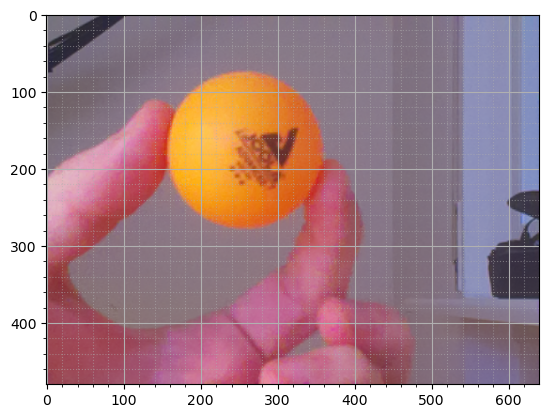

In [3]:
frame = get_frame();
def dense_grid():
	plt.grid()
	plt.gca().minorticks_on()
	plt.grid(which='minor', linestyle=':',alpha=0.5)
plt.imshow(frame)
dense_grid()
plt.show()

Modify the cell bellow to select the object:

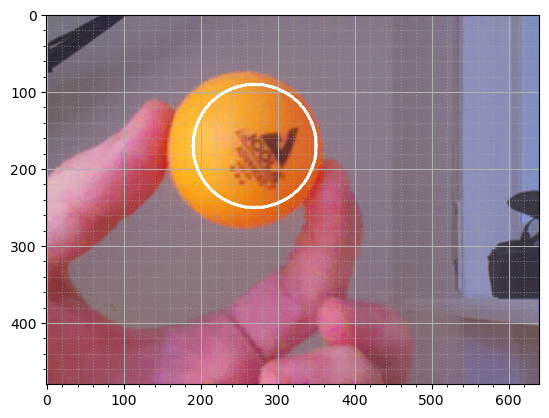

mean color: [163 156 184]
min: [ 65 136 138] max:[213 183 207]


In [7]:
center = (270, 170)
r = 80

mask = np.zeros(frame.shape[:2], np.uint8)
mask = cv2.circle(mask, center, r, 255, cv2.FILLED)

plt.imshow(frame)
dense_grid()
plt.contour(mask, colors="white")
plt.show()

# get lab values
frame_lab = cv2.cvtColor(frame, cv2.COLOR_RGB2LAB)
sel = frame_lab[mask.astype(bool)]
mean_lab = np.mean(sel, axis=0).astype(np.uint8)
min_lab = np.min(sel, axis=0)
max_lab = np.max(sel, axis=0)

print(f"mean color: {mean_lab}")
print(f"min: {min_lab} max:{max_lab}")

HSV and LAB take equal time, but LAB has a nice distance.

# Detector

array([253.35971402, 187.26399524])

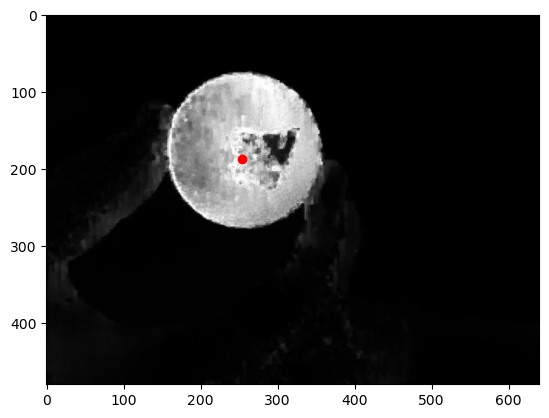

In [141]:
"""distance metric between two colors / images"""
def color_distance(a: np.ndarray, b: np.ndarray):
    return np.sum((a[..., 1:].astype(np.int16) - b[..., 1:].astype(np.int16))**2, axis=-1)

lab_range = color_distance(max_lab, min_lab)/10
lab_mean_frame = (np.ones_like(frame) * mean_lab).astype(np.int16)

def weights(frame_lab=frame_lab):
    dist = color_distance(frame_lab, lab_mean_frame)
    return np.exp(-dist/lab_range)

def center(weights=weights()): 
    return np.sum(np.indices(frame.shape[:2])*weights, axis=(1,2))[::-1]/np.sum(weights)

plt.imshow(weights(), vmin=0, cmap="gray")
plt.scatter([center()[0]], [center()[1]], color="red")
center()

In [142]:
%timeit color_distance(frame_lab, lab_mean_frame)

11.8 ms ± 58.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [130]:
%timeit weights()

15.6 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [131]:
%timeit center()

8.08 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
